## TS Final Project


### Import

In [1]:
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 155 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read Data

In [58]:
global_temp = pd.read_csv('drive/MyDrive/Colab Datasets/TS Final/imputed_Global.csv')

In [59]:
global_temp.head()

,Index,LandAverageTemperature
0,Jan 1750,3.034
1,Feb 1750,3.083
2,Mar 1750,5.626
3,Apr 1750,8.490
4,May 1750,11.573


In [60]:
global_temp.shape

(3192, 2)

In [61]:
global_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Index                   3192 non-null   object 
 1   LandAverageTemperature  3192 non-null   float64
dtypes: float64(1), object(1)
memory usage: 50.0+ KB


### GluonTS

#### Data Preprocess

In [ ]:
#!pip install gluonts

In [62]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

In [63]:
prediction_length = 36

In [64]:
global_temp["LandAverageTemperature"].values

array([ 3.034,  3.083,  5.626, ..., 10.801,  7.433,  5.518])

In [65]:
train_target_value = global_temp["LandAverageTemperature"].values[:-prediction_length]

In [66]:
len(train_target_value)

3156

In [67]:
test_target_value = global_temp["LandAverageTemperature"].values

In [68]:
len(test_target_value)

3192

In [69]:
m5_dates_train = [pd.Timestamp("1750-01-01", freq='1M')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  """Entry point for launching an IPython kernel.


In [70]:
m5_dates_test = [pd.Timestamp("1750-01-01", freq='1M')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  """Entry point for launching an IPython kernel.


In [71]:
train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start
    }
    for (target, start) in zip([train_target_value], m5_dates_train)
], freq="M")

In [72]:
test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start
    }
    for (target, start) in zip([test_target_value], m5_dates_test)
], freq="M")

In [73]:
train_ds.list_data

[{'start': Timestamp('1750-01-01 00:00:00', freq='M'),
  'target': array([ 3.034,  3.083,  5.626, ..., 10.428,  7.156,  4.102])}]

In [74]:
test_ds.list_data

[{'start': Timestamp('1750-01-01 00:00:00', freq='M'),
  'target': array([ 3.034,  3.083,  5.626, ..., 10.801,  7.433,  5.518])}]

#### Visualization

In [49]:
from gluonts.dataset.util import to_pandas

In [75]:
train_entry = next(iter(train_ds))
train_entry

{'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'target': array([ 3.034,  3.083,  5.626, ..., 10.428,  7.156,  4.102], dtype=float32)}

In [76]:
test_entry = next(iter(test_ds))
test_entry

{'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'target': array([ 3.034,  3.083,  5.626, ..., 10.801,  7.433,  5.518], dtype=float32)}

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


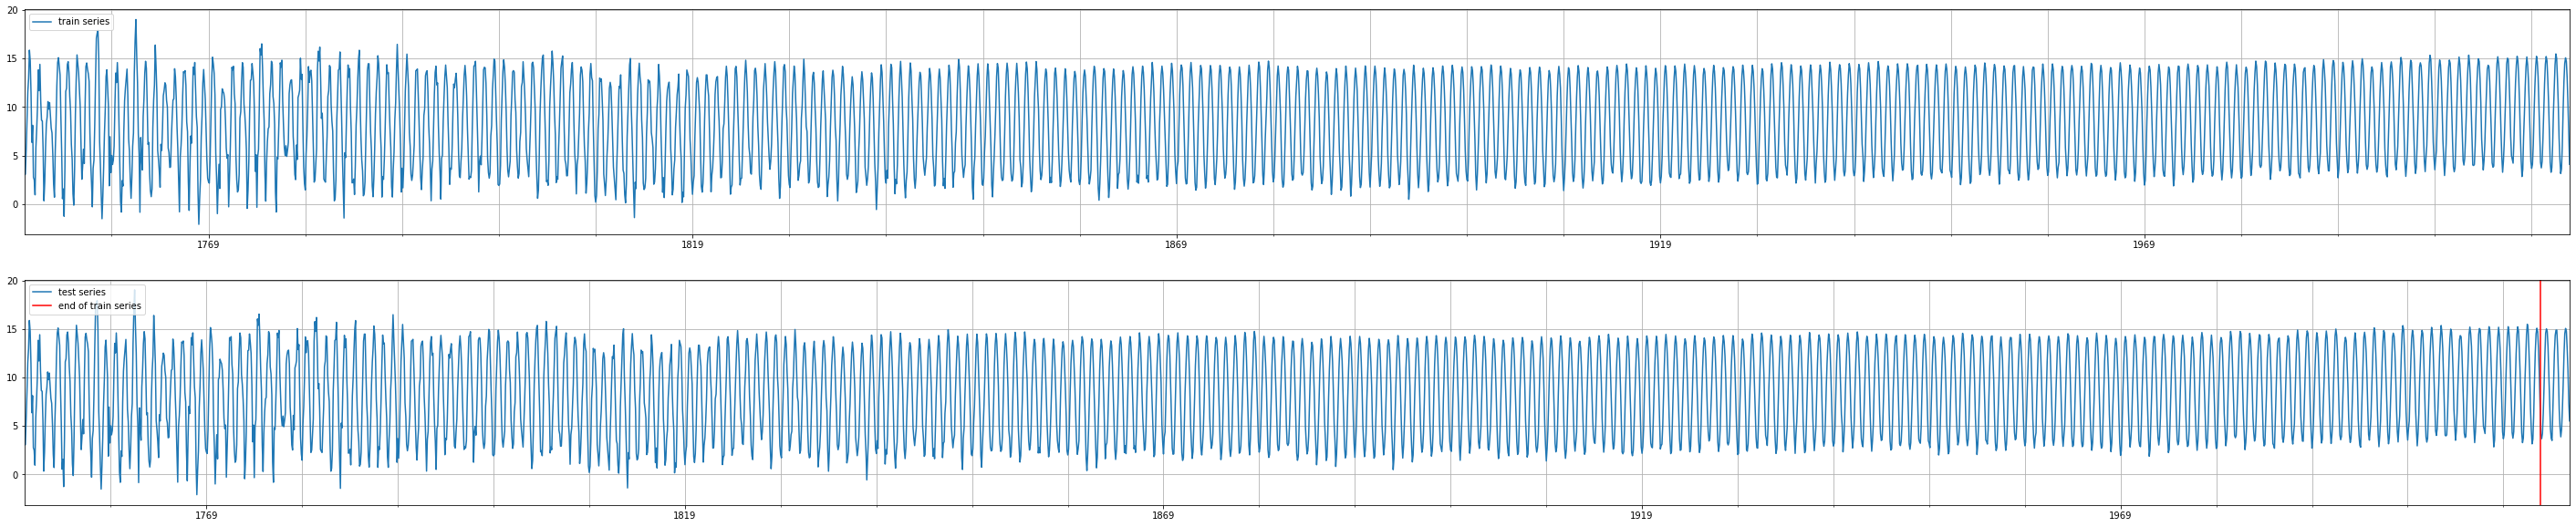

In [77]:
# Plot Train and Test Data
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(50, 10))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

#### Fit

In [78]:
import gluonts
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.trainer import Trainer

In [79]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="M",
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    trainer =Trainer(
        learning_rate=1e-3,
        epochs=100,
        num_batches_per_epoch=50,
        batch_size=32
    )
)

predictor = estimator.train(train_ds)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base = start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed i

Early stopping based on learning rate scheduler callback (min_lr was reached).


#### Predict

In [80]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


  0%|          | 0/1 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None


#### Evaluation

In [81]:
from gluonts.evaluation import Evaluator
    
class M5Evaluator(Evaluator):
    
    def get_metrics_per_ts(self, time_series, forecast):
        successive_diff = np.diff(time_series.values.reshape(len(time_series)))
        successive_diff = successive_diff ** 2
        successive_diff = successive_diff[:-prediction_length]
        denom = np.mean(successive_diff)
        pred_values = forecast.samples.mean(axis=0)
        true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
        num = np.mean((pred_values - true_values)**2)
        rmsse = num / denom
        metrics = super().get_metrics_per_ts(time_series, forecast)
        metrics["RMSE"] = np.sqrt(metrics["MSE"])
        metrics["RMSSE"] = rmsse
        return metrics
    
    def get_aggregate_metrics(self, metric_per_ts):
        wrmsse = metric_per_ts["RMSSE"].mean()
        agg_metric , _ = super().get_aggregate_metrics(metric_per_ts)
        agg_metric["MRMSSE"] = wrmsse
        return agg_metric, metric_per_ts
    

evaluator = M5Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 32.32it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq


{
    "MSE": 0.24864411354064941,
    "abs_error": 24.205997467041016,
    "abs_target_sum": 348.0979919433594,
    "abs_target_mean": 9.669388665093315,
    "seasonal_error": 0.6746086140018687,
    "MASE": 0.9967095061834692,
    "MAPE": 0.09165889687008327,
    "sMAPE": 0.09903197818332249,
    "MSIS": 18.735143054152996,
    "QuantileLoss[0.5]": 24.205997705459595,
    "Coverage[0.5]": 0.19444444444444445,
    "QuantileLoss[0.67]": 23.85532250881195,
    "Coverage[0.67]": 0.9444444444444444,
    "QuantileLoss[0.95]": 18.89020030498506,
    "Coverage[0.95]": 1.0,
    "QuantileLoss[0.99]": 5.5780400466919,
    "Coverage[0.99]": 1.0,
    "RMSE": 0.49864227011019574,
    "NRMSE": 0.05156916195853252,
    "ND": 0.0695378830883336,
    "wQuantileLoss[0.5]": 0.0695378837732516,
    "wQuantileLoss[0.67]": 0.06853048009737889,
    "wQuantileLoss[0.95]": 0.05426690398162013,
    "wQuantileLoss[0.99]": 0.016024338478802625,
    "mean_absolute_QuantileLoss": 18.132390141487125,
    "mean_wQuan

In [83]:
item_metrics[["MSE","RMSE","sMAPE"]]

,MSE,RMSE,sMAPE
0,0.248644,0.498642,0.099032


Plotting time series predictions ...


  0%|          | 0/1 [00:00<?, ?it/s]

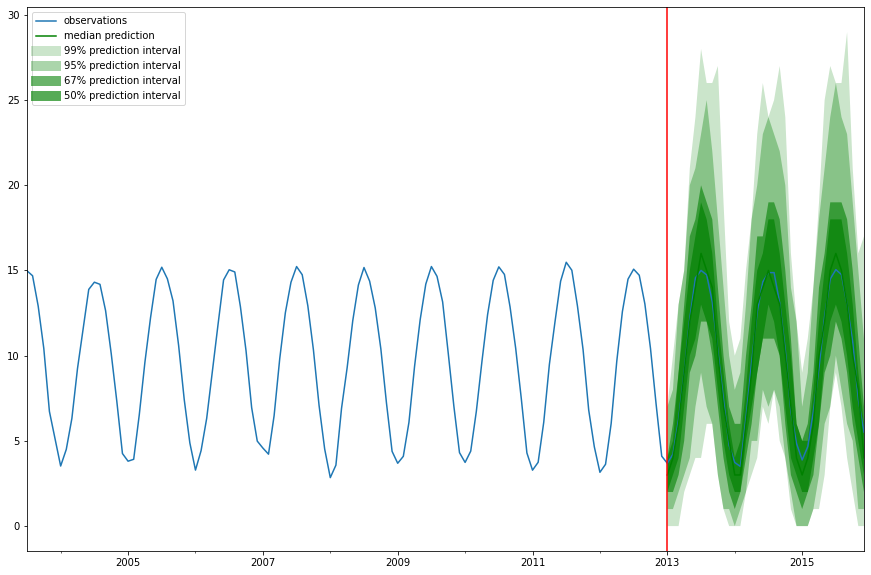

<Figure size 432x288 with 0 Axes>

In [161]:
def plot_prob_forecasts(ts_entry, forecast_entry, sample_id, inline=True):
    plot_length = 150
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(15, 10))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    plt.show()
    plt.clf()

print("Plotting time series predictions ...")
for i in tqdm(range(1)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, i)

## Asian Cities

In [8]:
shanghai = pd.read_csv('drive/MyDrive/Colab Datasets/TS Final/Cities/shanghai.csv',header=None)

In [9]:
shanghai.head()

,0,1
0,Jan 1849,3.326
1,Feb 1849,6.955
2,Mar 1849,9.445
3,Apr 1849,12.957
4,May 1849,18.813


In [10]:
seoul = pd.read_csv('drive/MyDrive/Colab Datasets/TS Final/Cities/seoul.csv',header=None)

In [11]:
berlin = pd.read_csv('drive/MyDrive/Colab Datasets/TS Final/Cities/berlin.csv',header=None)

In [12]:
cairo = pd.read_csv('drive/MyDrive/Colab Datasets/TS Final/Cities/cairo.csv',header=None)

In [13]:
mexico = pd.read_csv('drive/MyDrive/Colab Datasets/TS Final/Cities/mexico.csv',header=None)

In [14]:
los_angeles = pd.read_csv('drive/MyDrive/Colab Datasets/TS Final/Cities/los_angeles.csv',header=None)

In [15]:
melbourne = pd.read_csv('drive/MyDrive/Colab Datasets/TS Final/Cities/melbourne.csv',header=None)

In [16]:
london = pd.read_csv('drive/MyDrive/Colab Datasets/TS Final/Cities/london.csv',header=None)

In [17]:
!pip install gluonts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 5.1 MB/s 
     |████████████████████████████████| 11.1 MB 31.7 MB/s 


In [18]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [19]:
prediction_length = 36

In [20]:
train_target_value = [shanghai[1].values[:-prediction_length],seoul[1].values[:-prediction_length],
                      cairo[1].values[:-prediction_length],los_angeles[1].values[:-prediction_length],
                      mexico[1].values[:-prediction_length],berlin[1].values[:-prediction_length],
                      london[1].values[:-prediction_length],melbourne[1].values[:-prediction_length]]

In [21]:
test_target_value = [shanghai[1].values,seoul[1].values,
                      cairo[1].values,los_angeles[1].values,
                      mexico[1].values,berlin[1].values,
                      london[1].values,melbourne[1].values]

In [22]:
m5_dates_train = [pd.Timestamp("1849-01-01", freq='1M')]*8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  """Entry point for launching an IPython kernel.


In [23]:
m5_dates_test = [pd.Timestamp("1849-01-01", freq='1M')]*8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  """Entry point for launching an IPython kernel.


In [24]:
train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start
    }
    for (target, start) in zip(train_target_value, m5_dates_train)
], freq="M")

In [25]:
train_ds.list_data

[{'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([ 3.326,  6.955,  9.445, ..., 28.615, 30.128, 25.361])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([-2.502,  0.495,  4.232, ..., 24.737, 25.729, 21.278])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([12.102, 12.918, 17.061, ..., 29.5  , 30.597, 28.145])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([ 8.819,  9.577, 11.814, ..., 23.636, 23.545, 22.42 ])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([13.487, 13.445, 16.82 , ..., 17.668, 17.996, 17.083])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([-2.208,  3.268,  2.925, ..., 22.507, 18.692, 13.558])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([ 3.542,  5.723,  5.621, ..., 18.805, 16.242, 14.188])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([18.074, 17.73 , 

In [26]:
test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start
    }
    for (target, start) in zip(test_target_value, m5_dates_test)
], freq="M")

In [27]:
test_ds.list_data

[{'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([ 3.326     ,  6.955     ,  9.445     , ..., 30.623     ,
         30.493     , 24.69693716])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([-2.502     ,  0.495     ,  4.232     , ..., 24.852     ,
         26.791     , 21.41738347])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([12.102     , 12.918     , 17.061     , ..., 28.217     ,
         28.588     , 26.49595614])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([ 8.819,  9.577, 11.814, ..., 25.09 , 24.232, 23.301])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([13.487, 13.445, 16.82 , ..., 18.091, 17.882, 18.313])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target': array([-2.208     ,  3.268     ,  2.925     , ..., 20.901     ,
         19.335     , 15.49089376])},
 {'start': Timestamp('1849-01-01 00:00:00', freq='M'),
  'target

In [28]:
import gluonts
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx.trainer import Trainer

In [29]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="M",
    distr_output = NegativeBinomialOutput(),
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    trainer =Trainer(
        learning_rate=1e-3,
        epochs=100,
        num_batches_per_epoch=50,
        batch_size=32
    )
)

predictor = estimator.train(train_ds)

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:338: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base = start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helpe

In [30]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


  0%|          | 0/8 [00:00<?, ?it/s]

Obtaining time series predictions ...


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None


In [31]:
from gluonts.evaluation import Evaluator

class M5Evaluator(Evaluator):
    
    def get_metrics_per_ts(self, time_series, forecast):
        successive_diff = np.diff(time_series.values.reshape(len(time_series)))
        successive_diff = successive_diff ** 2
        successive_diff = successive_diff[:-prediction_length]
        denom = np.mean(successive_diff)
        pred_values = forecast.samples.mean(axis=0)
        true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
        num = np.mean((pred_values - true_values)**2)
        rmsse = num / denom
        metrics = super().get_metrics_per_ts(time_series, forecast)
        metrics["RMSE"] = np.sqrt(metrics["MSE"])
        metrics["RMSSE"] = rmsse
        return metrics
    
    def get_aggregate_metrics(self, metric_per_ts):
        wrmsse = metric_per_ts["RMSSE"].mean()
        agg_metric , _ = super().get_aggregate_metrics(metric_per_ts)
        agg_metric["MRMSSE"] = wrmsse
        return agg_metric, metric_per_ts
    

evaluator = M5Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 8/8 [00:00<00:00, 217.14it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq



{
    "MSE": 2.504259851243761,
    "abs_error": 358.3043327331543,
    "abs_target_sum": 4306.229553222656,
    "abs_target_mean": 14.952185948689777,
    "seasonal_error": 1.2510689220754765,
    "MASE": 1.05098604960818,
    "MAPE": 0.7978641274902555,
    "sMAPE": 0.23217469784948563,
    "MSIS": 18.20055915496203,
    "QuantileLoss[0.5]": 358.3043261319399,
    "Coverage[0.5]": 0.548611111111111,
    "QuantileLoss[0.67]": 442.8761240240931,
    "Coverage[0.67]": 0.888888888888889,
    "QuantileLoss[0.95]": 221.6162484988572,
    "Coverage[0.95]": 0.9826388888888888,
    "QuantileLoss[0.99]": 69.33044975608591,
    "Coverage[0.99]": 0.9826388888888888,
    "RMSE": 1.582485339977518,
    "NRMSE": 0.10583638709470351,
    "ND": 0.0832060456380013,
    "wQuantileLoss[0.5]": 0.08320604410505598,
    "wQuantileLoss[0.67]": 0.10284545181588324,
    "wQuantileLoss[0.95]": 0.0514641046790007,
    "wQuantileLoss[0.99]": 0.01610003575034708,
    "mean_absolute_QuantileLoss": 273.031787102744

In [34]:
titles = ["shanghai","seoul","cairo","los_angeles","mexico","berlin","london","melbourne"]
item_metrics["item_id"]=titles
eva = item_metrics[["item_id","MSE","RMSE","sMAPE"]]
eva

,item_id,MSE,RMSE,sMAPE
0,shanghai,1.993003,1.411737,0.129479
1,seoul,4.683622,2.164168,0.585630
2,cairo,2.316617,1.522044,0.057431
3,los_angeles,1.765426,1.328693,0.074289
4,mexico,1.270047,1.126964,0.064262
5,berlin,3.489849,1.868114,0.631344
6,london,3.070322,1.752233,0.241006
7,melbourne,1.445194,1.202162,0.073958


Plotting time series predictions ...


  0%|          | 0/8 [00:00<?, ?it/s]

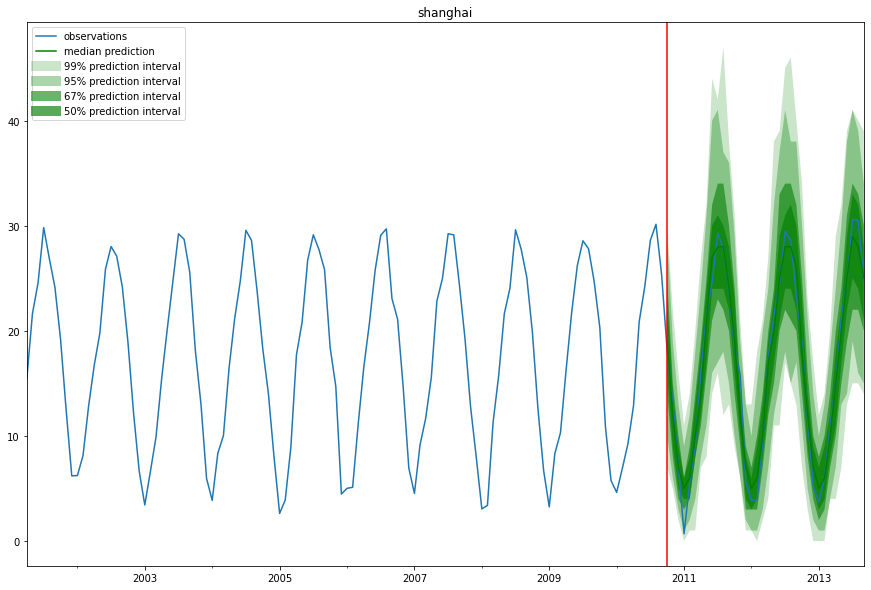

<Figure size 432x288 with 0 Axes>

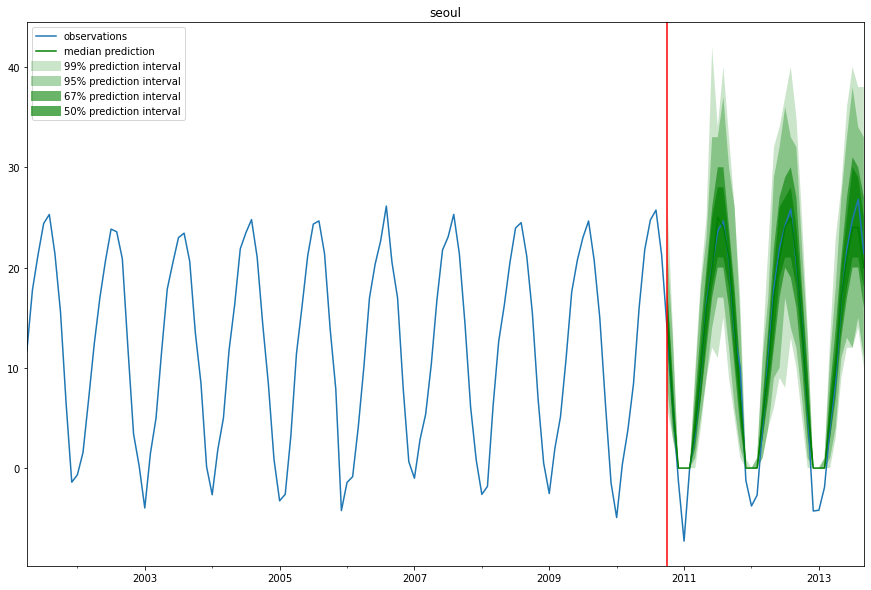

<Figure size 432x288 with 0 Axes>

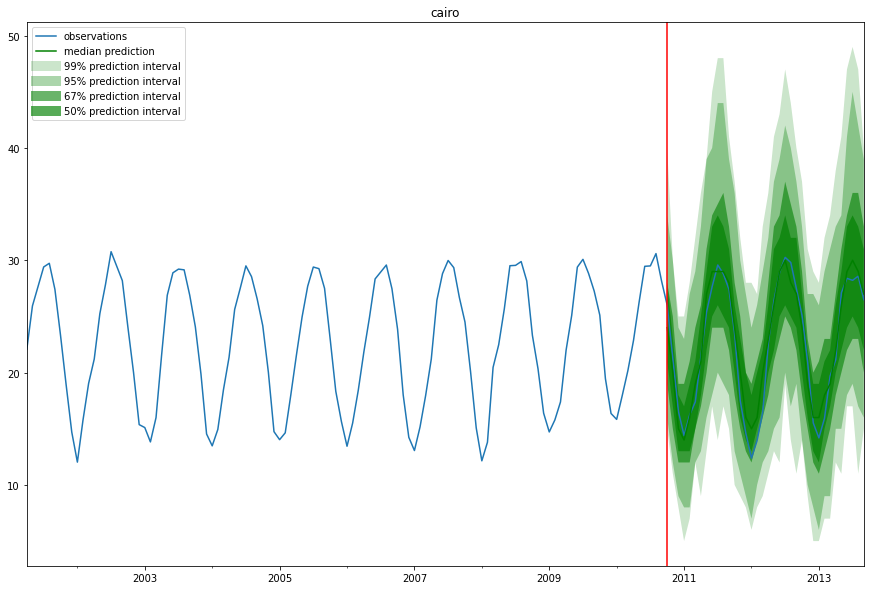

<Figure size 432x288 with 0 Axes>

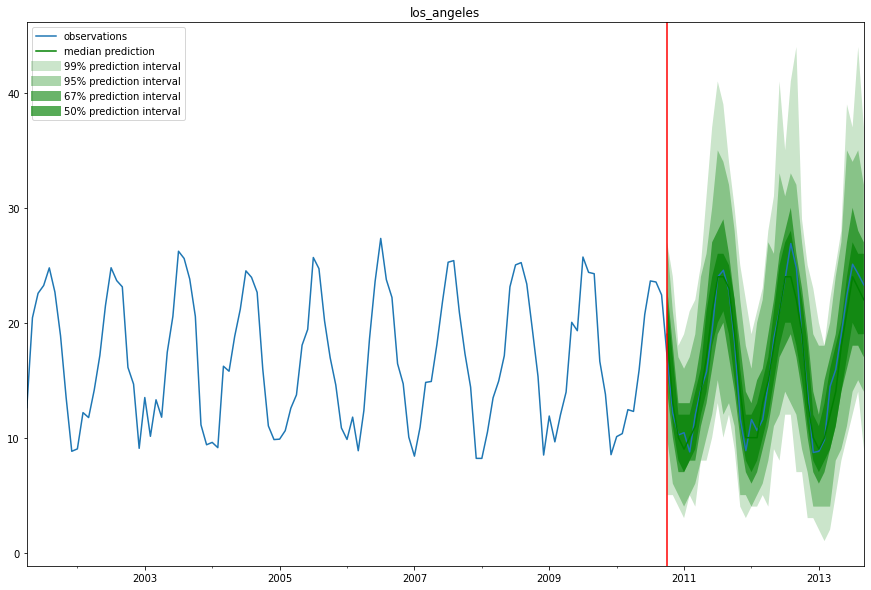

<Figure size 432x288 with 0 Axes>

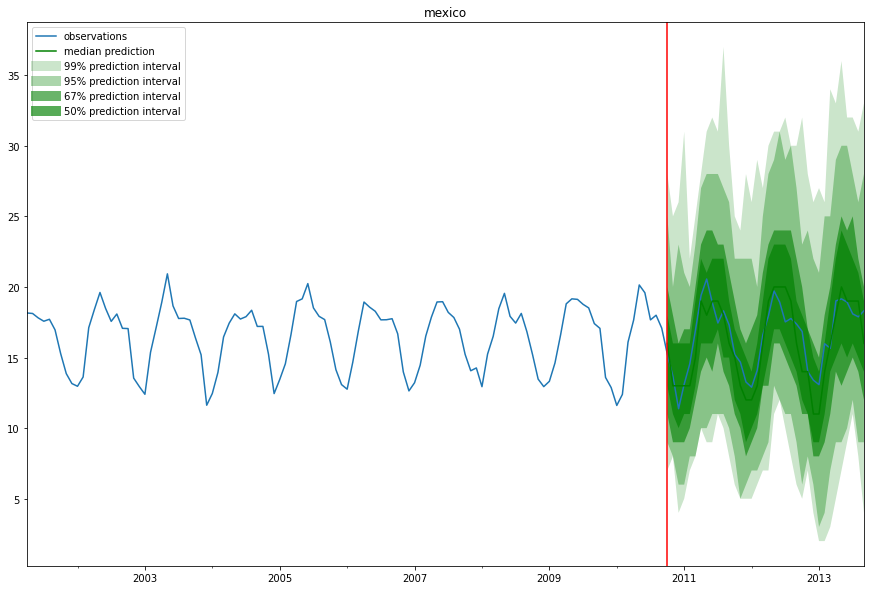

<Figure size 432x288 with 0 Axes>

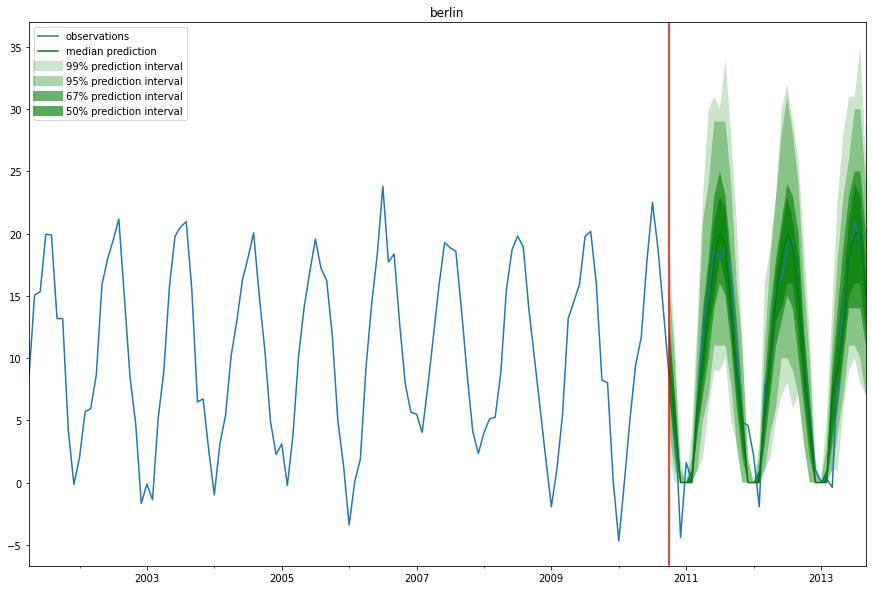

<Figure size 432x288 with 0 Axes>

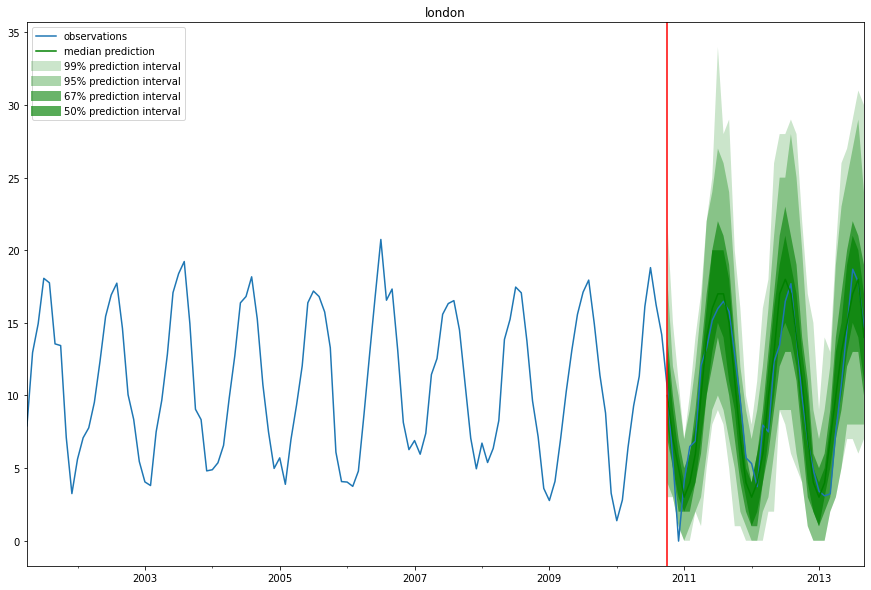

<Figure size 432x288 with 0 Axes>

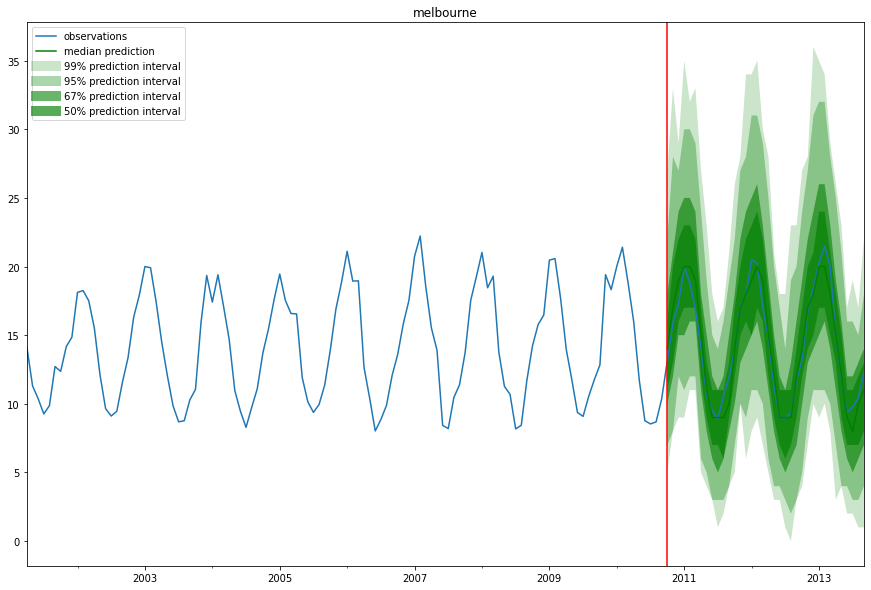

<Figure size 432x288 with 0 Axes>

In [67]:
titles = ["shanghai","seoul","cairo","los_angeles","mexico","berlin","london","melbourne"]
def plot_prob_forecasts(ts_entry, forecast_entry, sample_id, titles,inline=True):
    plot_length = 150
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(15, 10))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    plt.title(titles[sample_id])
    plt.show()
    plt.clf()

print("Plotting time series predictions ...")
for i in tqdm(range(8)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, i,titles)